In [32]:
# Initialize Otter
import otter
grader = otter.Notebook("hw07.ipynb")

<a id="top"></a>

# Homework 7: IMDb

We will use SQL to dive deep into the Internet Movie Database (IMDb) and answer different questions involving movies, actors, and movie ratings.

## Due Date: Thursday, April 17th, 11:59 PM

You must submit this assignment to Gradescope by the on-time deadline, Thursday, April 17th, 11:59 PM. Please read the syllabus for the Slip Day policy. No late submissions beyond what is outlined in the Slip Day policy will be accepted. **We strongly encourage you to submit your work to Gradescope several hours before the deadline.** This way, you will have ample time to reach out to staff for support if you encounter difficulties with submission. While course staff is happy to help guide you with submitting your assignment ahead of the deadline, we will not respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully when submitting your work to Gradescope. 


##  Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** below.

**Collaborators**: *list collaborators here*

## Grading 

Grading is broken down into autograded answers and free response. For autograded answers, the results of your code are compared to provided and/or hidden tests. For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

<!--
<details>
    <summary>[Click to Expand] <b>Scoring Breakdown</b></summary>-->
|Question| Manual | Points|
|---|---|---|
|1a | No | 2 |
|1b | No | 2 |
|2 | No | 3 |
|3 | No | 3 |
|4a | No | 4 |
|4b | Yes | 2 |
|5 | No | 4 |
|Total | 1 |20 |
</details>

## Before You Start

For each question in the assignment, please write down your answer in the answer cell(s) right below the question. 

We understand that it is helpful to have extra cells breaking down the process towards reaching your final answer. If you happen to create new cells below your answer to run code, **NEVER** add cells between a question cell and the answer cell below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.

**Important note: Please only have ONE active SQL database running at once on DataHub, meaning do not have multiple homework/lab/lecture notebooks running at the same time**

**Important note: The local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.


### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). In this guide, you can find general questions about Jupyter notebooks / Datahub, Gradescope, common SQL errors, and more.

In [33]:
# Run this cell to set up your notebook; no further action is needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sqlalchemy
from pathlib import Path
import sql

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
np.set_printoptions(threshold=5) # Avoid printing out big matrices
%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## The IMDB (mini) Dataset

We will explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we used for this week's lab.

**Caution: Be careful with large SQL queries!!** You may need to reboot your Jupyter Hub instance if it stops responding. To avoid printing out 100k-sized tables, we've adjusted the display limit to ensure that the tables displayed are truncated to 20 rows (though they may contain more rows in reality).

In [34]:
%config SqlMagic.displaylimit = 20
%config SqlMagic.style = 'DEFAULT'

Let's set up the SQL database.

## Question 1 - Setup

Please just run the cells below to set up your SQL database and the autograder.

In [35]:
import duckdb

In [36]:
# Run this cell to connect to the database
conn = duckdb.connect()
conn.query("INSTALL sqlite")

In [37]:
%sql duckdb:///data/imdbmini.db

Let's take a look at the table schemas:

In [38]:
%%sql
-- just run this cell --
SELECT * FROM sqlite_master WHERE type='table';

Running query in 'duckdb:///data/imdbmini.db'

type,name,tbl_name,rootpage,sql
table,Title,Title,0,"CREATE TABLE Title(tconst BIGINT, titleType VARCHAR, primaryTitle VARCHAR, originalTitle VARCHAR, isAdult VARCHAR, startYear VARCHAR, endYear VARCHAR, runtimeMinutes VARCHAR, genres VARCHAR);"
table,Name,Name,0,"CREATE TABLE ""Name""(nconst BIGINT, primaryName VARCHAR, birthYear VARCHAR, deathYear VARCHAR, primaryProfession VARCHAR);"
table,Role,Role,0,"CREATE TABLE ""Role""(tconst BIGINT, ordering VARCHAR, nconst BIGINT, category VARCHAR, job VARCHAR, characters VARCHAR);"
table,Rating,Rating,0,"CREATE TABLE Rating(tconst BIGINT, averageRating VARCHAR, numVotes VARCHAR);"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details open>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema below. You can also find it in the `schemas.txt` file, which is in the same directory as this notebook. We have only included descriptions for columns that could be of potential use in this homework. </summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (BIGINT) - alphanumeric unique identifier of the name/person
- primaryName (VARCHAR) - name by which the person is most often credited
- birthYear (VARCHAR) - in YYYY format
- deathYear (VARCHAR) - in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (BIGINT) - alphanumeric unique identifier of the title
- ordering (VARCHAR) - a number to uniquely identify rows for a given tconst
- nconst (BIGINT) - alphanumeric unique identifier of the name/person
- category (VARCHAR) - the category of job that person was in
- characters (VARCHAR) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and vote information for titles.
    
- tconst (BIGINT) - alphanumeric unique identifier of the title
- averageRating (VARCHAR) – weighted average of all the individual user ratings
- numVotes (VARCHAR) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (BIGINT) - alphanumeric unique identifier of the title
- titleType (VARCHAR) -  the type/format of the title
- primaryTitle (VARCHAR) -  the more popular title / the title used by the producers on promotional materials at the point of release
- isAdult (VARCHAR) - 0: non-adult title; 1: adult title
- startYear (VARCHAR) - represents the release year of a title.
- runtimeMinutes (VARCHAR) - primary runtime of the title, in minutes
    
</details>

<br/><br/>
From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

For a refresher on how to write SQL queries in Jupyter, feel free to reference the start of Lab 10. The main thing to keep in mind is that you can directly write your query in place of the ellipsis under `%%sql --save query_q`. **Please do not edit this line.** 

For example, we can set `query_example` to the output of the following SQL query and directly see what it contains: 

In [39]:
%%sql --save query_example
-- This is a one-line SQL comment.
/* This is a multi-line
   SQL comment. */
SELECT * 
FROM name
LIMIT 15;

Running query in 'duckdb:///data/imdbmini.db'

nconst,primaryName,birthYear,deathYear,primaryProfession
1,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
2,Lauren Bacall,1924,2014,"actress,soundtrack"
3,Brigitte Bardot,1934,None,"actress,soundtrack,music_department"
4,John Belushi,1949,1982,"actor,soundtrack,writer"
5,Ingmar Bergman,1918,2007,"writer,director,actor"
6,Ingrid Bergman,1915,1982,"actress,soundtrack,producer"
7,Humphrey Bogart,1899,1957,"actor,soundtrack,producer"
8,Marlon Brando,1924,2004,"actor,soundtrack,director"
9,Richard Burton,1925,1984,"actor,soundtrack,producer"
10,James Cagney,1899,1986,"actor,soundtrack,director"


In [40]:
%%sql
SELECT * 
FROM role
LIMIT 15;

Running query in 'duckdb:///data/imdbmini.db'

tconst,ordering,nconst,category,job,characters
417,1,617588,actor,None,"[""Prof. Barbenfouillis"",""The Moon""]"
417,2,29244,actor,None,"[""Astronomer""]"
417,3,76933,actress,None,"[""Lady in the Moon""]"
417,4,1215996,actor,None,"[""Astronomer""]"
417,5,894523,writer,"novel ""De la Terre à la Lune""",None
417,6,920229,writer,"novel ""First Men in the Moon""",None
417,7,242155,composer,None,None
417,8,324073,composer,None,None
417,9,4491570,composer,None,None
4972,10,376221,editor,None,None


In [41]:
%%sql
SELECT * 
FROM name
LIMIT 15;

Running query in 'duckdb:///data/imdbmini.db'

nconst,primaryName,birthYear,deathYear,primaryProfession
1,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
2,Lauren Bacall,1924,2014,"actress,soundtrack"
3,Brigitte Bardot,1934,None,"actress,soundtrack,music_department"
4,John Belushi,1949,1982,"actor,soundtrack,writer"
5,Ingmar Bergman,1918,2007,"writer,director,actor"
6,Ingrid Bergman,1915,1982,"actress,soundtrack,producer"
7,Humphrey Bogart,1899,1957,"actor,soundtrack,producer"
8,Marlon Brando,1924,2004,"actor,soundtrack,director"
9,Richard Burton,1925,1984,"actor,soundtrack,producer"
10,James Cagney,1899,1986,"actor,soundtrack,director"


<br/>

---

### Question 1a  
Let's determine whether our database includes information going back to the early days of cinema or just more recent data.

List the **10 oldest movie titles** by `startYear` and then `primaryTitle` both in **ascending** order. The output should contain the `startYear`, `primaryTitle`, and `titleType`. In this homework, we define a movie as having `titleType='movie'`. Keep this in mind for later questions as well.
                                                                                                                               

In [42]:
%%sql --save query_q1a

SELECT startYear, primaryTitle, titleType
FROM Title
WHERE titleType = 'movie'
ORDER BY startYear ASC, primaryTitle ASC
LIMIT 10;


Running query in 'duckdb:///data/imdbmini.db'

startYear,primaryTitle,titleType
1915,The Birth of a Nation,movie
1920,The Cabinet of Dr. Caligari,movie
1921,The Kid,movie
1922,Nosferatu,movie
1924,Sherlock Jr.,movie
1925,Battleship Potemkin,movie
1925,The Gold Rush,movie
1926,The General,movie
1927,Metropolis,movie
1927,Sunrise,movie


In [43]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q1a
res_q1a = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [44]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

---

### Question 1b

Next, let's calculate the distribution of movies by year. Write a query that returns the **total** number of movie titles for each `startYear` in the `Title` table as `total`. Order your final results by the `startYear` in **ascending** order. As in `q1a`, remember that movies are defined as having `titleType=’movie’`.

The first few records of the table should look like the following (but you should compute the entire table):


|startYear|total|
|------:|-----:|
| 1915|1|
| 1920|1|
| 1921|1|
| 1922|1|
| ...|...|



In [45]:
%%sql --save query_q1b

SELECT startYear, COUNT(*) AS total
FROM Title
WHERE titleType = 'movie'
GROUP BY startYear
ORDER BY startYear ASC;


Running query in 'duckdb:///data/imdbmini.db'

startYear,total
1915,1
1920,1
1921,1
1922,1
1924,1
1925,2
1926,1
1927,2
1928,2
1929,1


In [46]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q1b
res_q1b = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [47]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

The following cell should generate an interesting plot of the number of movies that premiered each year. Notice there are fewer movies premiering from the 1920s to the late 1940s. Why might that be? *This question is rhetorical; you do not need to write your answer anywhere.*

In [48]:
# Run this call to generate the bar plot; no further action is needed
px.bar(res_q1b, x="startYear", y="total", 
        title="Number of movies premiered each year", 
        width=900, height=400)

<br/>

---

## Question 2

Write a SQL query to determine the movie producers with the highest average ratings across all of their movies. The term **"movie actor"** is defined as anyone with an `"actor"` or `"actress"` job category role in a `"movie"` title type released after 1980.

Your SQL query should output exactly two fields named `name` (the movie actor's name) and `total` (the number of movies the movie actor appears in). Order the records by `total` in **descending** order, and break ties by ordering by `name` in **ascending** order.

Your result should look something like this (but without `????`):

| name | total |
|-----:|-----:|
| ???? | 58 |
| ???? | 54 |
| ???? | 53 |
| ???? | 49 |
| ???? | 46 |
| ???? | 43 |
| ???? | 41 |
| ???? | 40 |
| ???? | 40 |
| ???? | 39 |

**Notes**: 
* **The query should take < 2 minutes to run.**
* Sometimes Python gets confused and colors some SQL queries red; *don't worry if the SQL coloring doesn't match what you'd expect*. As long as it runs, it's fine.

**Hints**:

* Before writing your query, you may wish to review the table descriptions given at the start of the assignment to determine where the information you need is stored
* If you want to include a non-aggregate field in the `SELECT` clause, it must also be included in the `GROUP BY` clause.
* When using multiple conditions in a `WHERE` clause, pay attention to the order of operations.

In [49]:
%%sql --save query_q2
SELECT 
    n.primaryName AS name,
    COUNT(*) AS total
FROM 
    Name AS n
JOIN 
    Role AS r ON n.nconst = r.nconst
JOIN 
    Title AS t ON r.tconst = t.tconst
WHERE 
    r.category IN ('actor', 'actress')
    AND t.titleType = 'movie'
    AND CAST(t.startYear AS INT) > 1980
GROUP BY 
    n.primaryName
ORDER BY 
    total DESC,
    name ASC
LIMIT 10;



Running query in 'duckdb:///data/imdbmini.db'

name,total
Robert De Niro,58
Samuel L. Jackson,54
Nicolas Cage,53
Bruce Willis,49
Tom Hanks,46
Johnny Depp,43
Mark Wahlberg,41
Liam Neeson,40
Morgan Freeman,40
Adam Sandler,39


In [50]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q2
res_q2 = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [51]:
grader.check("q2")

q2 results: All test cases passed!

<br/>

---

## Question 3: The `CASE` Keyword

The `rating` table has the `numVotes` and the `averageRating` for each title. A movie is considered a **"big hit**" if there are more than 100,000 votes for the movie. Which `movie` titles were **"big hits"**? Construct a query that generates the following result:

| isBigHit | total |
|-----:|-----|
| no | ???? |
| yes | ???? |

Where `????` is replaced with the correct values. The row with `no` should have the count for how many movies **are not** big hits, and the row with `yes` should have the count of how many movies **are** big hits.

**Hints**:

* Check the data types of `numVotes` before performing any arithmetic operations.
* You will need to use some type of `JOIN`.
* You may also consider using a `CASE` statement:
    ```
    CASE 
        WHEN ... THEN ...
        ELSE ... 
    END
    ```
    </br>
    
  `CASE` statements are the SQL equivalent of `Python` `if... elif... else` statements. To read up on `CASE`, take a look at the following links:
    - https://mode.com/sql-tutorial/sql-case/
    - https://www.w3schools.com/sql/sql_ref_case.asp


In [52]:
%%sql --save query_q3

SELECT
    CASE 
        WHEN CAST(r.numVotes AS INT) > 100000 THEN 'yes'
        ELSE 'no'
    END AS isBigHit,
    COUNT(*) AS total
FROM 
    Title AS t
JOIN 
    Rating AS r ON t.tconst = r.tconst
WHERE 
    t.titleType = 'movie'
GROUP BY 
    isBigHit
ORDER BY 
    isBigHit ASC;


Running query in 'duckdb:///data/imdbmini.db'

isBigHit,total
no,4318
yes,2041


In [53]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q3
res_q3 = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [54]:
grader.check("q3")

q3 results: All test cases passed!

<br/>

---

## Question 4

Let's compute the average runtime and average rating for `movie` titles by release year and examine how they evolve to see how the movie runtimes and ratings have changed over time.

### Question 4a

We will group movies by their release year (`startYear`). For each year, compute:
- the **average runtime** of all movies (as `avgRuntime`)
- the **average IMDb rating** (as `avgRating`)

Construct a query that generates a table containing the `startYear`, `avgRuntime`, and `avgRating`. Only include movies with **at least 25,000 votes**. Order the final results by the value of `startYear` in ascending order.

**Hints**:  
* Like in previous questions, we are only focusing on **movies**.
* Check the data types of `runtimeMinutes`, `averageRating`, and `startYear` before performing any arithmetic operations — you should `CAST` them to `int`, `float`, and `int` respectively.
* You may define computed columns (e.g., `avgRuntime`) in your `SELECT` clause and reference them in the output.

**Note**: DO NOT cast `averageRating` as an integer. Doing so reduces the precision of the resulting values. See the hint above for what you should cast instead!

In [55]:
%%sql --save query_q4a

SELECT
    CAST(t.startYear AS INT) AS startYear,
    AVG(CAST(t.runtimeMinutes AS FLOAT)) AS avgRuntime,
    AVG(CAST(r.averageRating AS FLOAT)) AS avgRating
FROM 
    Title AS t
JOIN 
    Rating AS r ON t.tconst = r.tconst
WHERE 
    t.titleType = 'movie'
    AND CAST(r.numVotes AS INT) >= 25000
    AND t.startYear != '\N'
    AND t.runtimeMinutes != '\N'
GROUP BY 
    CAST(t.startYear AS INT)
ORDER BY 
    startYear ASC;


Running query in 'duckdb:///data/imdbmini.db'

startYear,avgRuntime,avgRating
1920,76.0,8.100000381469727
1921,68.0,8.300000190734863
1922,94.0,7.900000095367432
1924,45.0,8.199999809265137
1925,85.0,8.099999904632568
1926,67.0,8.100000381469727
1927,123.5,8.200000286102295
1928,91.0,8.100000381469727
1930,152.0,8.100000381469727
1931,87.25,8.025000095367432


In [56]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q4a
res_q4a = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [57]:
grader.check("q4a")

q4a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

### Question 4b

Create two line plots below. The first should show how the **average movie runtime** has changed over time; the second should show how the **average movie rating** has changed over time. The x-axis should be `startYear` for both plots. Use the columns from the table generated in the previous part, `res_q4a`.

**Notes**:
* Please use `sns` or `plt` functions for plotting.
* Please include descriptive titles and labels.
* If your plot does not show up in the generated PDF, please upload a PDF with a screenshot of your code and the plot.

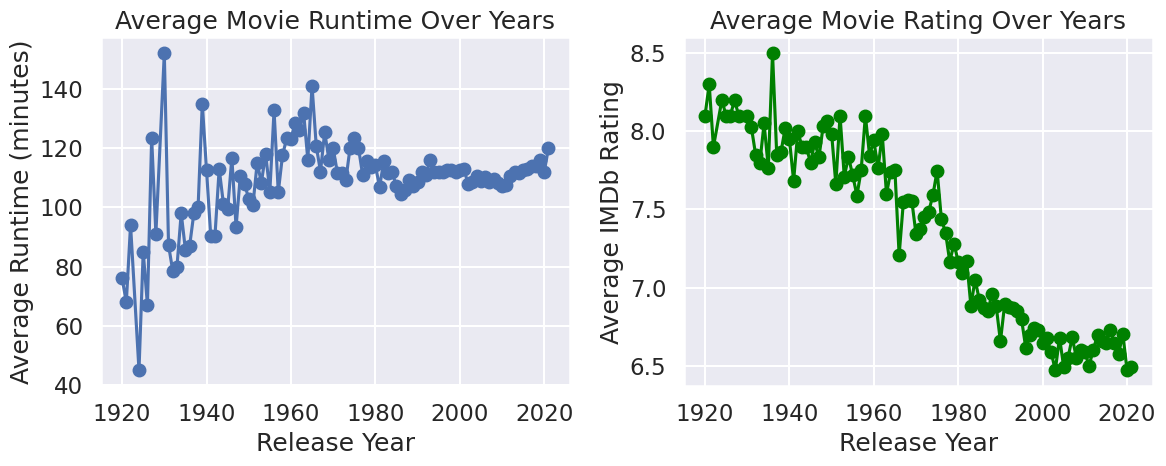

In [58]:
plt.figure(figsize=(12, 5))

# First subplot: Average Runtime
plt.subplot(1, 2, 1)  # DO NOT MODIFY THIS LINE
plt.plot(res_q4a['startYear'], res_q4a['avgRuntime'], marker='o')
plt.title('Average Movie Runtime Over Years')
plt.xlabel('Release Year')
plt.ylabel('Average Runtime (minutes)')
plt.grid(True)

# Second subplot: Average Rating
plt.subplot(1, 2, 2)  # DO NOT MODIFY THIS LINE
plt.plot(res_q4a['startYear'], res_q4a['avgRating'], marker='o', color='green')
plt.title('Average Movie Rating Over Years')
plt.xlabel('Release Year')
plt.ylabel('Average IMDb Rating')
plt.grid(True)

plt.tight_layout()

##### Write 1–2 sentences describing any trends you observe in each plot. This will be graded for completion.

For Average Movie Runtime Over Years:

    Over time, movies have gradually gotten longer. In the early 1900s, the average movie was around 70 to 90 minutes, but in more recent years, runtimes have often gone past 110 minutes.

For Average Movie Rating Over Years:

    The average movie rating has been slowly dropping since around the 1950s. Movies used to average above 8.0, but nowadays they tend to fall closer to 6.5 or 7.0

<!-- END QUESTION -->

<br/>

---

## Question 5

Write a SQL query to determine the movie producers with the highest average ratings across all of their movies. Define a **"movie producer"** as anyone with a `producer` job category role in a `movie` title type. Construct a query that generates a table consisting of the **producer's name** (as `name`) and their **average producer rating** (as `producerRating`), computed by rescaling the ratings for movies they produced by the number of votes received by each movie. After rescaling the score for each movie, divide the summation of all rescaled ratings by the total number of votes received by each producer. The formula is below:

$$
\text{producerRating} = 
\frac{\sum_m (\text{averageRating}[m] * \text{numVotes}[m] )}{\sum_m \text{numVotes}[m]}
$$

To make clear the summation, "m" refers to a particular movie that a producer worked on. Thus, the summation over "m" refers to the summation across all movies that a particular producer contributed to.

In addition to the above, only consider ratings where there are **at least 22,500** votes and only consider movie producers that have **at least 20 rated movies**. Present the producers with the **top 10** `producerRating` in **descending** order and break ties alphabetically using the producer's name.

The results should look something like this but without the `????`, and with higher rating precision.

| name            | producerRating |
|-----------------|----------------|
| ???             | 7.76...        |
| ???             | 7.62...        |
| ???             | 7.59...        |
| ???             | 7.43...        |
| ???             | 7.41...        |
| ???             | 7.35...        |
| ???             | 7.30...        |
| ???             | 7.27...        |
| ???             | 7.25...        |
| ???             | 7.24...        |

**Hint**: Check the data types of `numVotes` and `averageRating` before performing any arithmetic operations.

**Notes**:
* ***The query should take < 3 minutes to run.***
* DO NOT cast `averageRating` **as an integer**. Doing so reduces the precision of the resulting values, so your table may not match up exactly with what is shown below.
* If a producer has multiple `role` listings for a movie, then that movie will have a bigger impact on the overall average (this is desired).


In [59]:
%%sql --save query_q5

WITH producer_movies AS (
    SELECT
        n.primaryName AS name,
        r.tconst,
        CAST(rt.averageRating AS FLOAT) AS averageRating,
        CAST(rt.numVotes AS INT) AS numVotes
    FROM 
        Role AS r
    JOIN 
        Name AS n ON r.nconst = n.nconst
    JOIN 
        Title AS t ON r.tconst = t.tconst
    JOIN 
        Rating AS rt ON t.tconst = rt.tconst
    WHERE 
        r.category = 'producer'
        AND t.titleType = 'movie'
        AND CAST(rt.numVotes AS INT) >= 22500
),
producer_aggregates AS (
    SELECT
        name,
        SUM(averageRating * numVotes) AS weighted_rating_sum,
        SUM(numVotes) AS total_votes,
        COUNT(DISTINCT tconst) AS movie_count
    FROM 
        producer_movies
    GROUP BY 
        name
)
SELECT
    name,
    (weighted_rating_sum * 1.0) / total_votes AS producerRating
FROM 
    producer_aggregates
WHERE 
    movie_count >= 20
ORDER BY 
    producerRating DESC,
    name ASC
LIMIT 10;


Running query in 'duckdb:///data/imdbmini.db'

name,producerRating
Charles Roven,7.768761772894268
Steve Golin,7.628543557354401
David Heyman,7.592145954135472
Kathleen Kennedy,7.4340628083807845
Joel Silver,7.415345829886901
Scott Rudin,7.353150451071015
Dede Gardner,7.302534315612741
Mark Johnson,7.277885869580468
Eric Fellner,7.250872208287768
Denise Di Novi,7.244045762946653


In [60]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q5
res_q5 = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [61]:
grader.check("q5")

q5 results: All test cases passed!


<br><br>


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Chanel and Opal congratulate you for finishing Homework 7!

<img src="images/chanel.jpg" width="240"/> <img src="images/opal.jpg" width="320"/>

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/e/1FAIpQLSdpKA_E3b7PGqKSRqBUgSebb9bVFhRwRBv1ueisGsnKFkZkYg/viewform?usp=sf_link). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Homework 7 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Homework 7 Written assignment. If you run into any issues when running this cell, feel free to check the ["Why did a Gradescope test fail when all the Jupyter notebook’s tests passed?"](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-did-a-gradescope-test-fail-when-all-the-jupyter-notebooks-tests-passed) section of the Data 100 Debugging Guide.

If there are issues with automatically generating the PDF, try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work, download the notebook as an HTML file by clicking on `File -> Save and Export Notebook As... -> HTML`, open the HTML file in your browser, and Ctrl + P or Cmd + P (Mac) to save the file as a PDF. Alternatively, you can  manually take screenshots of your answers to the manually graded questions and submit a PDF containing those. 

**You are responsible for ensuring your submission follows our requirements and that everything was generated and submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [62]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q2 results: All test cases passed!

    q3 results: All test cases passed!

    q4a results: All test cases passed!

    q5 results: All test cases passed!
